#**Text-to-Image using DCGAN**

##**1.Data Preparing**



*   Download the flowers caption data: [link](https://drive.google.com/file/d/0B0ywwgffWnLLcms2WWJQRFNSWXM/view?resourcekey=0-Av8zFbeDDvNcF1sSjDR32w)
*   Download the flowers image data: [link](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)
*   Download the flowers caption embedding: [link](https://drive.google.com/file/d/0B0ywwgffWnLLMl9uOU91MV80cVU/view?resourcekey=0-vy4hVV-6Hvpw3AiYipoa3g)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q torchfile

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import h5py
import torchfile
import numpy as np
from glob import glob

In [ ]:
%cd /content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 09/[Exercise]-DCGAN

/content/drive/MyDrive/AI_VIETNAM/AIO2023/Module 09/[Exercise]-DCGAN


In [ ]:
images_path = './data/'
text_path = './data/cvpr2016_flowers/text_c10/'
save_dataset_path = './data/flowers.hdf5'

train_path = './data/flowers_icml/trainclasses.txt'
val_path = './data/flowers_icml/valclasses.txt'
test_path = './data/flowers_icml/testclasses.txt'

In [ ]:
train_classes = open(train_path).read().splitlines()
val_classes = open(val_path).read().splitlines()
test_classes = open(test_path).read().splitlines()

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from transformers import AutoTokenizer, DistilBertModel

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
model.to(device)
model.eval()

# Max Pooling - Take the max value over time for every dimension.
def max_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
    return torch.max(token_embeddings, 1)[0]

def convert_text_to_feature(sentences, max_length=50):
    inputs = tokenizer.batch_encode_plus(
        sentences, padding='max_length', max_length=max_length, truncation=True, return_tensors='pt'
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    sentence_embeddings = max_pooling(outputs, attention_mask)
    return sentence_embeddings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

##**2. Dataset**

In [ ]:
import io
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class Text2ImageDataset(Dataset):

    def __init__(self, dataset_path, transform=None, split=0):
        self.dataset_path = dataset_path
        self.transform = transform
        self.dataset = h5py.File(self.dataset_path, mode='r')
        self.split = 'train' if split == 0 else 'val' if split == 1 else 'test'
        self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        length = len(self.dataset[self.split])
        return length

    def __getitem__(self, idx):
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:

            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        embeddings = convert_text_to_feature([str(txt)]).detach().cpu()

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': embeddings[0],
                'wrong_images': torch.FloatTensor(wrong_image),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def validate_image(self, img):
        img = np.array(img, dtype=float)
        return img.transpose(2, 0, 1)

In [ ]:
train_dataset = Text2ImageDataset(save_dataset_path, split=0)
val_dataset = Text2ImageDataset(save_dataset_path, split=1)
test_dataset = Text2ImageDataset(save_dataset_path, split=2)

In [ ]:
next(iter(train_dataset))

{'right_images': tensor([[[-0.0745, -0.2706, -0.3255,  ..., -0.8980, -0.9059, -0.8745],
          [-0.0275, -0.1294, -0.1216,  ..., -0.8980, -0.9137, -0.8980],
          [-0.0980, -0.0353, -0.0118,  ..., -0.8980, -0.9137, -0.8902],
          ...,
          [-0.2235, -0.0980, -0.1216,  ..., -0.6078, -0.5216, -0.4353],
          [-0.1922, -0.1451,  0.2706,  ..., -0.6000, -0.4980, -0.4196],
          [-0.0118,  0.1059,  0.5059,  ..., -0.5843, -0.4980, -0.4510]],
 
         [[-0.1137, -0.2784, -0.2314,  ..., -0.8824, -0.8902, -0.8588],
          [-0.0118, -0.0902, -0.0667,  ..., -0.8824, -0.8980, -0.8824],
          [-0.0275,  0.0667,  0.0824,  ..., -0.8824, -0.8980, -0.8745],
          ...,
          [-0.1843, -0.1059, -0.1216,  ..., -0.7647, -0.7020, -0.6235],
          [-0.1294, -0.1451,  0.1922,  ..., -0.7569, -0.6706, -0.5922],
          [ 0.0667,  0.1059,  0.3569,  ..., -0.7333, -0.6549, -0.6000]],
 
         [[-0.3412, -0.6471, -0.7255,  ..., -0.9843, -0.9922, -0.9608],
          [-

In [ ]:
from torch.utils.data import DataLoader

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

##**3.Model**

In [ ]:
import torch
import torch.nn as nn
# The Generator model
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Generator architecture
        model = []
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Apply text embedding to the input text
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)  # Reshape to match the generator input size
        z = torch.cat([text, noise], 1)  # Concatenate text embedding with noise
        return self.model(z)


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
        out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
        return out


# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            *self._create_layer(64, 128, 4, 2, 1),
            *self._create_layer(128, 256, 4, 2, 1),
            *self._create_layer(256, 512, 4, 2, 1)
        )
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)  # Text embedding module
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        x_out = self.model(x)  # Extract features from the input using the discriminator architecture
        out = self.text_embedding(x_out, text)  # Apply text embedding and concatenate with the input features
        out = self.output(out)  # Final discriminator output
        return out.squeeze(), x_out

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
embed_dim = 768
noise_dim = 100
embed_out_dim = 64
generator = Generator(
    channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim
).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

In [ ]:
discriminator = Discriminator(
    channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim
).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=768, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momen

##**4.Training**

In [ ]:
# setting up Adam optimizer for Generator and Discriminator
learning_rate = 0.0002
optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999)
)

# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
len(train_loader)

15

In [ ]:
import time

num_epochs = 20
real_label = 1.
fake_label = 0.
l1_coef = 50
l2_coef = 100

D_losses = []
G_losses = []

for epoch in range(num_epochs):
    epoch_D_loss = []
    epoch_G_loss = []
    batch_time = time.time()

    for idx, batch in enumerate(train_loader):

        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Clear gradients for the discriminator
        optimizer_D.zero_grad()

        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake image batch with the generator
        fake_images = generator(noise, embeddings)

        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake

        # Backpropagate the gradients
        d_loss.backward()

        # Update the discriminator
        optimizer_D.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Clear gradients for the generator
        optimizer_G.zero_grad()

        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)

        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)

        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)

        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2

        # Backpropagate the gradients
        g_loss.backward()

        # Update the generator
        optimizer_G.step()

        epoch_D_loss.append(d_loss.item())
        epoch_G_loss.append(g_loss.item())

    print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, idx+1, len(train_loader),
        d_loss.mean().item(),
        g_loss.mean().item(),
        time.time() - batch_time)
    )
    D_losses.append(sum(epoch_D_loss)/len(epoch_D_loss))
    G_losses.append(sum(epoch_G_loss)/len(epoch_G_loss))

Epoch 1 [15/15] loss_D: 2.0083 loss_G: 37.8380 time: 618.30
Epoch 2 [15/15] loss_D: 1.8261 loss_G: 31.8287 time: 590.07
Epoch 3 [15/15] loss_D: 1.8939 loss_G: 26.7808 time: 590.47
Epoch 4 [15/15] loss_D: 1.4179 loss_G: 27.9727 time: 593.88
Epoch 5 [15/15] loss_D: 1.5960 loss_G: 27.4269 time: 592.49
Epoch 6 [15/15] loss_D: 1.7019 loss_G: 25.2765 time: 593.25
Epoch 7 [15/15] loss_D: 1.7825 loss_G: 24.8765 time: 595.84
Epoch 8 [15/15] loss_D: 1.8914 loss_G: 26.6624 time: 594.05
Epoch 9 [15/15] loss_D: 1.5864 loss_G: 25.1170 time: 596.76
Epoch 10 [15/15] loss_D: 1.6421 loss_G: 25.2865 time: 593.69
Epoch 11 [15/15] loss_D: 1.8172 loss_G: 24.4648 time: 593.32
Epoch 12 [15/15] loss_D: 1.6164 loss_G: 25.5750 time: 593.53
Epoch 13 [15/15] loss_D: 1.6049 loss_G: 24.6646 time: 598.01
Epoch 14 [15/15] loss_D: 1.6659 loss_G: 25.7569 time: 602.60
Epoch 15 [15/15] loss_D: 1.6609 loss_G: 24.6488 time: 602.92
Epoch 16 [15/15] loss_D: 1.9769 loss_G: 26.2371 time: 601.52
Epoch 17 [15/15] loss_D: 2.4125 l

In [ ]:
!mkdir save_model

In [ ]:
model_save_path = './save_model'
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_bert.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_bert.pth'))

In [ ]:
generator.eval()

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(164, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False

##**5.Prediction**

In [ ]:
example = next(iter(test_dataset))

In [ ]:
example

{'right_images': tensor([[[-0.3098, -0.3569, -0.3333,  ..., -0.8667, -0.8667, -0.8824],
          [-0.3255, -0.3333, -0.3647,  ..., -0.8902, -0.8667, -0.8745],
          [-0.3098, -0.3098, -0.3804,  ..., -0.9059, -0.8824, -0.8745],
          ...,
          [-0.3804, -0.6549, -0.8824,  ..., -0.6941, -0.7333, -0.7647],
          [-0.4824, -0.7176, -0.8510,  ..., -0.6392, -0.7020, -0.6941],
          [-0.6549, -0.7255, -0.8275,  ..., -0.6157, -0.6941, -0.6157]],
 
         [[ 0.2392,  0.1922,  0.2314,  ..., -0.7804, -0.8353, -0.8824],
          [ 0.2549,  0.2078,  0.2000,  ..., -0.7882, -0.8353, -0.8745],
          [ 0.2706,  0.2627,  0.1922,  ..., -0.7961, -0.8667, -0.8667],
          ...,
          [ 0.0510, -0.2863, -0.7569,  ..., -0.8039, -0.7490, -0.7176],
          [-0.0588, -0.3647, -0.6941,  ..., -0.8431, -0.8667, -0.8510],
          [-0.2784, -0.4039, -0.6706,  ..., -0.8196, -0.8745, -0.8118]],
 
         [[ 0.3961,  0.2627,  0.2941,  ..., -0.8118, -0.8745, -0.9216],
          [ 

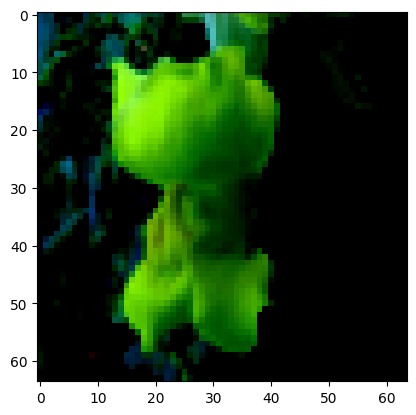

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example['right_images'].permute(1, 2, 0))
plt.show()

In [ ]:
example['txt']

'this flower consists of large yellow-green petals that are vertically oriented.\n'

In [ ]:
sentence = example['txt']
embeddings = convert_text_to_feature([str(sentence)])

In [ ]:
embeddings.shape

torch.Size([1, 768])

In [ ]:
sentence = example['txt']
embeddings = convert_text_to_feature([str(sentence)])

noise = torch.randn(1, noise_dim, 1, 1, device=device)
pred = generator(noise, embeddings.unsqueeze(0))

In [ ]:
embeddings = embeddings.detach()

In [ ]:
embeddings

tensor([[ 1.0245e+00,  6.5829e-01,  5.1052e-01,  6.0084e-01,  5.5474e-01,
          3.3252e-01,  4.3268e-01,  9.0475e-01,  8.5826e-01,  3.0934e-01,
          3.3643e-01, -1.6599e-01,  1.2825e-01,  7.7875e-01, -1.3336e-01,
          1.2278e+00,  1.4875e+00,  8.0312e-01,  1.4052e-01,  6.8556e-01,
          7.0399e-01,  2.7877e-01,  3.3860e-01,  3.7521e-01,  1.7319e+00,
          2.0216e-01,  1.9279e-01,  7.5270e-01,  5.3134e-01,  6.1896e-01,
          5.2557e-01,  3.3776e-01,  6.4362e-01,  6.9931e-01,  3.7452e-01,
          5.0589e-01,  6.5202e-01,  4.5603e-02,  1.0592e-01,  6.1629e-01,
          3.3343e-01,  2.4266e-01,  2.1315e-01,  3.2154e-01,  7.2999e-01,
         -1.2212e-01,  2.9834e-01,  6.3961e-01,  6.4802e-01,  7.5071e-01,
          3.2432e-01,  8.2290e-01,  2.3994e-01,  4.5662e-01,  9.0643e-01,
          1.2648e+00,  2.8709e-01,  3.2500e-01,  1.4617e-01, -2.3937e-01,
          9.7963e-02,  7.4524e-01,  5.6356e-01,  3.7232e-01,  1.1037e+00,
          8.8132e-01,  1.3763e-01,  1.

In [ ]:
noise = torch.randn(1, noise_dim, 1, 1, device=device)
pred = generator(noise, embeddings)

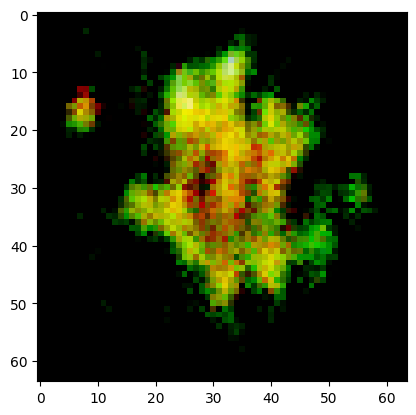

In [ ]:
plt.imshow(pred[0].cpu().detach().permute(1, 2, 0))
plt.show()